In [1]:
import tensorflow as tf
import numpy as np
import tqdm

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [3]:
np.random.seed(1)
tf.random.set_seed(1)
batch_size = 128
epochs = 1000
learning_rate = 1e-2
intermediate_dim = 64
original_dim = 784

(training_features, _), _ = tf.keras.datasets.mnist.load_data()
training_features = training_features / np.max(training_features)
training_features = training_features.reshape(training_features.shape[0],
                                              training_features.shape[1] * training_features.shape[2])
training_features = training_features.astype('float32')
training_features=training_features[:300]
training_dataset = tf.data.Dataset.from_tensor_slices(training_features)
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(training_features.shape[0])
training_dataset = training_dataset.prefetch(batch_size * 4)

TypeError: 'PrefetchDataset' object is not subscriptable

In [7]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim):
    super(Encoder, self).__init__()
    self.hidden_layer = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    self.output_layer = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.sigmoid
    )
    
  def call(self, input_features):
    activation = self.hidden_layer(input_features)
    return self.output_layer(activation)

In [8]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, original_dim):
    super(Decoder, self).__init__()
    self.hidden_layer = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    self.output_layer = tf.keras.layers.Dense(
      units=original_dim,
      activation=tf.nn.sigmoid
    )
  
  def call(self, code):
    activation = self.hidden_layer(code)
    return self.output_layer(activation)

In [9]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(
      intermediate_dim=intermediate_dim,
      original_dim=original_dim
    )
  
  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  original_dim=original_dim
)
opt = tf.optimizers.Adam(learning_rate=learning_rate)

def loss(model, original):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
  return reconstruction_error
  
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model, original), model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)


In [16]:
from matplotlib import pyplot as plt

In [6]:
training_dataset

<PrefetchDataset shapes: (None, 784), types: tf.float32>

In [31]:
writer = tf.summary.create_file_writer('tmp')
from tqdm import trange
with writer.as_default():
  with tf.summary.record_if(True):
    for epoch in trange(epochs):
      for step, batch_features in enumerate(training_dataset):
        train(loss, autoencoder, opt, batch_features)
        loss_values = loss(autoencoder, batch_features)
        original = tf.reshape(batch_features, (batch_features.shape[0], 28, 28, 1))
        reconstructed = tf.reshape(autoencoder(tf.constant(batch_features)), (batch_features.shape[0], 28, 28, 1))

        tf.summary.scalar('loss', loss_values, step=step)
        tf.summary.image('original', original, max_outputs=10, step=step)
        tf.summary.image('reconstructed', reconstructed, max_outputs=10, step=step)

100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


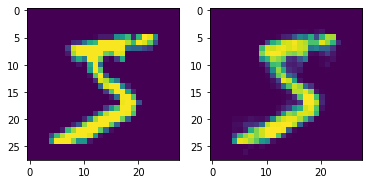

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(original[0])
axarr[1].imshow(reconstructed[0])

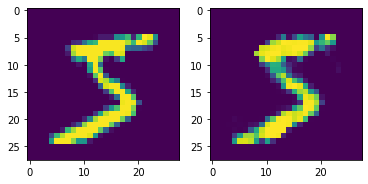

In [32]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(original[0])
axarr[1].imshow(reconstructed[0])